In [1]:
import pandas as pd
import numpy as np
import datetime 
import os
import seaborn as sns; sns.set()
import datetime as dt
import collections
import pyplot_themes as themes
import itertools
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from icecream import ic
from nltk.util import bigrams 
import os
from sklearn.preprocessing import StandardScaler

# Define functions to use for smoothing, setting plot settings and getting tweet frequencies

In [31]:
def smooth_5000(compound, nroftweets, small):
    if compound:
        if small:
            print("Compound FWHM = 500")
        else:
            print("Compound FWHM = 5000")
    if nroftweets:
        if small:
            print("Nr FWHM = 500")
        else:
            print("Nr FWHM = 5000")
    return 0

def set_base_plot_settings(fontsize, if_palette):
    matplotlib.rc('ytick', labelsize=fontsize)
    matplotlib.rc('xtick', labelsize=fontsize)
    themes.theme_minimal(grid=False, ticks=False, fontsize=fontsize)
    a4_dims = (25,15)
    
    if if_palette:
        #          0 black      1 orange  2 L blue   3 green    4 L orange  5 D blue  6 D orange 7 purple
        palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    else:
        palette = 0
    
    fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
    sns.set(font_scale = 2)

    return fig, ax1, palette

def set_late_plot_settings(if_dates):
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)

    ax1.grid(color='darkgrey', linestyle='-', linewidth=0.5, which= "both")
    if if_dates:
        # Define the date format
        ax1.xaxis_date()
        date_form = mdates.DateFormatter("%d-%b")
        ax1.xaxis.set_major_formatter(date_form)

    ax1.set(ylim=(0, None))
    
    return fig, ax1

def set_late_barplot_settings():
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)
        
    return fig, ax1

def get_tweet_frequencies(df):
    # Add freq of tweets by themselves in the dataset
    # pd.DataFrame creates a new datafrme where "number of tweets" is now the column and it is filled with the associated number
    tweet_freq = pd.DataFrame({'nr_of_tweets' : df.groupby(['date']).size()}).reset_index()
    #merge 
    freq_tweets = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    
    return freq_tweets    


### Define keyword searched for

In [48]:
data_prefix = "omicron-denmark"
map_prefix = f"{data_prefix}_files"

In [49]:
if not os.path.exists("../fig"):
    os.makedirs("../fig")
if not os.path.exists(f"../fig/{data_prefix}"):
    os.makedirs(f"../fig/{data_prefix}")

### Load file, prepare date column and z-score and smooth polarity score

In [50]:
filename= os.path.join("..", map_prefix, f"{data_prefix}_final.csv")
df = pd.read_csv(filename,lineterminator='\n')
df = df.sort_values("created_at")
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')
df["date"] = pd.to_datetime(df["date"])

### Pick start date for tweets - optional

In [51]:
start_date = "2021-10-01" #datetime.date(2021, 1, 1)
df = df[df['date'] >= start_date]

In [52]:
# Count number of tweets per search keyword
# df.groupby("search_keyword").count()
#Total number of tweets
print(f'dates go from {min(df["date"])} to {max(df["date"])} and total number of tweets is {len(df.index)}')
df.head()
# Stops at 2021-03-21 

dates go from 2021-11-15 00:00:00 to 2022-01-16 00:00:00 and total number of tweets is 21448


,Unnamed: 0,index,created_at,id,text,date,mentioneless_text,text50,dupe50,nr_of_tweets,...,normalized_entropy,centered_entropy,s200_compound,s200_nr_of_tweets,s500_compound,s500_nr_of_tweets,date_ordinal,hashtags,tokens_list,tokens_string
0,0,0,2021-11-15T00:01:44.000Z,1460035249602117632,Interesting in the NYT on trust and the pandem...,2021-11-15,Interesting in the NYT on trust and the pandem...,Interesting in the NYT on trust and the pandem...,False,169,...,0.636285,-0.021925,0.091601,165.707195,0.055818,139.168772,738109,[],"['interesting', 'in', 'the', 'on', 'trust', 't...",interesting in the on trust the pandemic respo...
1,1,1,2021-11-15T00:02:10.000Z,1460035359644045324,@prinspire3d @joslyoung @BredaOC95090320 @scot...,2021-11-15,Perhaps if we didn't allow right wing me...,Perhaps if we didn't allow right wing me...,False,169,...,0.636285,-0.021925,0.091357,165.646022,0.055705,139.088836,738109,[],"['perhaps', 'if', 'we', 'didnt', 'allow', 'rig...",perhaps if we didnt allow right wing medium du...
2,2,2,2021-11-15T00:05:33.000Z,1460036212861898755,@MonicaGandhi9 You said we need to learn from ...,2021-11-15,You said we need to learn from Denmark. See w...,You said we need to learn from Denmark. See w...,False,169,...,0.636285,-0.021925,0.091111,165.583832,0.055591,139.008776,738109,[],"['you', 'said', 'we', 'need', 'learn', 'from',...",you said we need learn from denmark see what s...
3,3,3,2021-11-15T00:12:12.000Z,1460037882664525826,@Bravehard54 @PeterSweden7 Sweden has also had...,2021-11-15,Sweden has also had many more people die of ...,Sweden has also had many more people die of ...,False,169,...,0.636285,-0.021925,0.090864,165.520611,0.055478,138.928592,738109,[],"['sweden', 'has', 'also', 'had', 'many', 'more...",sweden has also had many more people die of co...
4,4,4,2021-11-15T00:27:20.000Z,1460041691948150787,Recommended 👇👇\n\nDenmark 🇩🇰\n- has high soci...,2021-11-15,Recommended \n\nDenmark \n- has high social &...,Recommended \n\nDenmark \n- has high social &...,False,169,...,0.636285,-0.021925,0.090617,165.456345,0.055364,138.848284,738109,[],"['recommended', 'denmark', 'has', 'high', 'soc...",recommended denmark has high social amp instit...


### Get the frequencies of tweets summed over days

In [53]:
df = get_tweet_frequencies(df.drop("nr_of_tweets", axis=1))

# Plotting tweet frequency over time

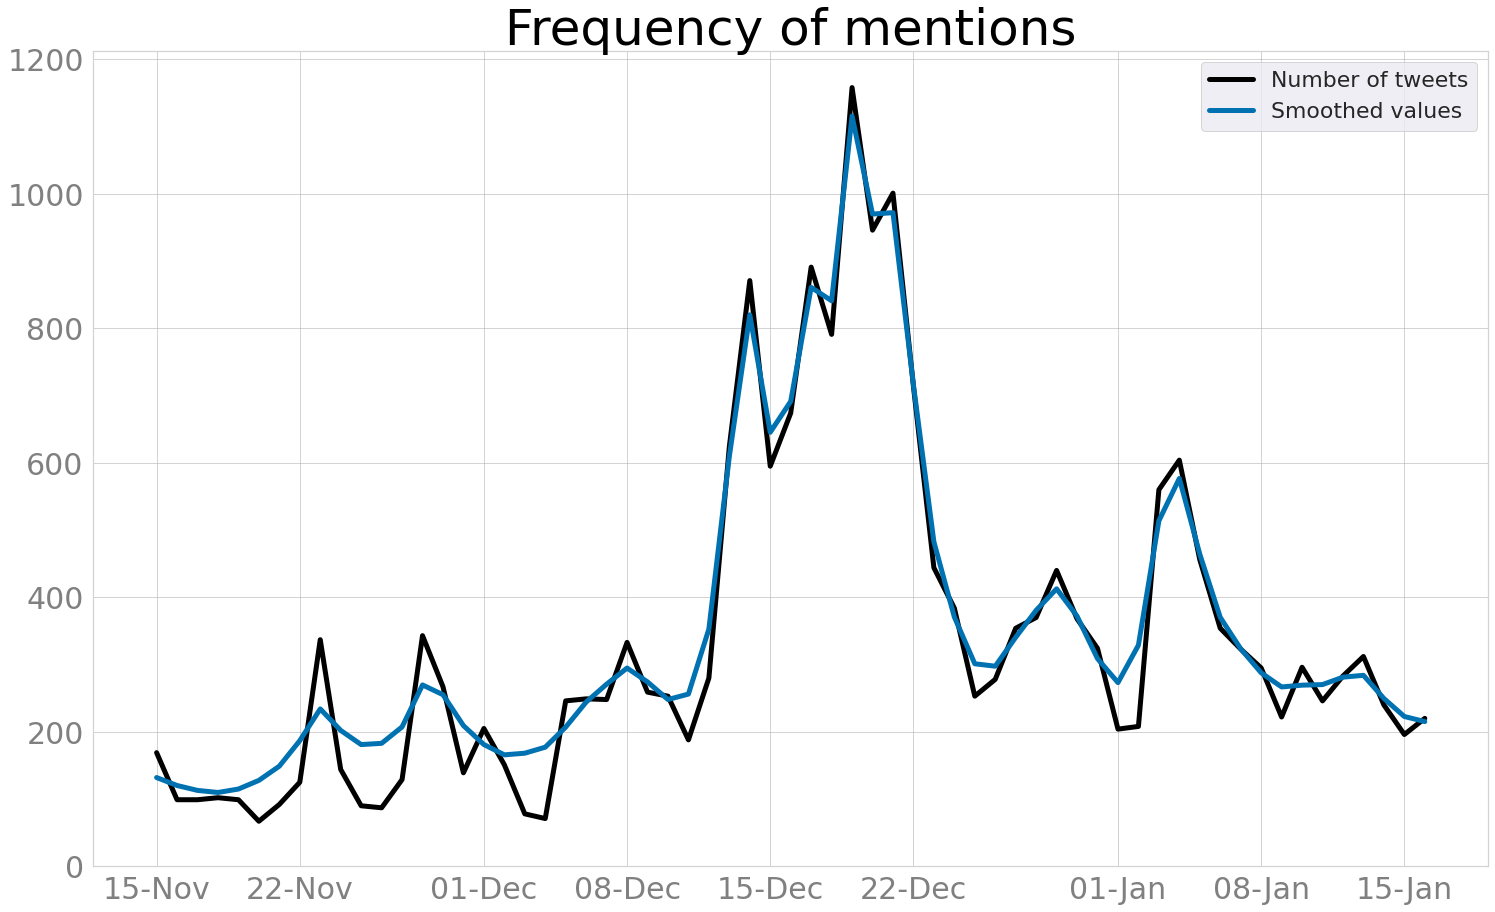

In [55]:
smoothing_value = 500
save = True

fig, ax1, palette = set_base_plot_settings(fontsize=30, if_palette = True)

ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   #alpha = 0.30,
                     linewidth = 5, data = df)

ax1 = sns.lineplot(x="date", y=f"s{smoothing_value}_nr_of_tweets", 
                  color = palette[5], 
                     linewidth = 5, data = df)

# For jul split
# ax1 = sns.lineplot(x="date", y=f"split_smooth_nrtweets_{smoothing_value}", 
#                   color = palette[5], 
#                      linewidth = 5, data = df)



fig, ax1 = set_late_plot_settings(if_dates = True)
plt.legend(labels=['Number of tweets', "Smoothed values"])
ax1.set_title("Frequency of mentions", fontdict = {'fontsize':50}, color = "Black")

plot_name = f"../fig/{data_prefix}/{data_prefix}_freq_{smoothing_value}.png"
if save:
    fig.savefig(plot_name)

fig.show()

# Sentiment over time

### Sum over week instead of day

In [56]:
df["Week"] = df["date"].dt.strftime('%V')

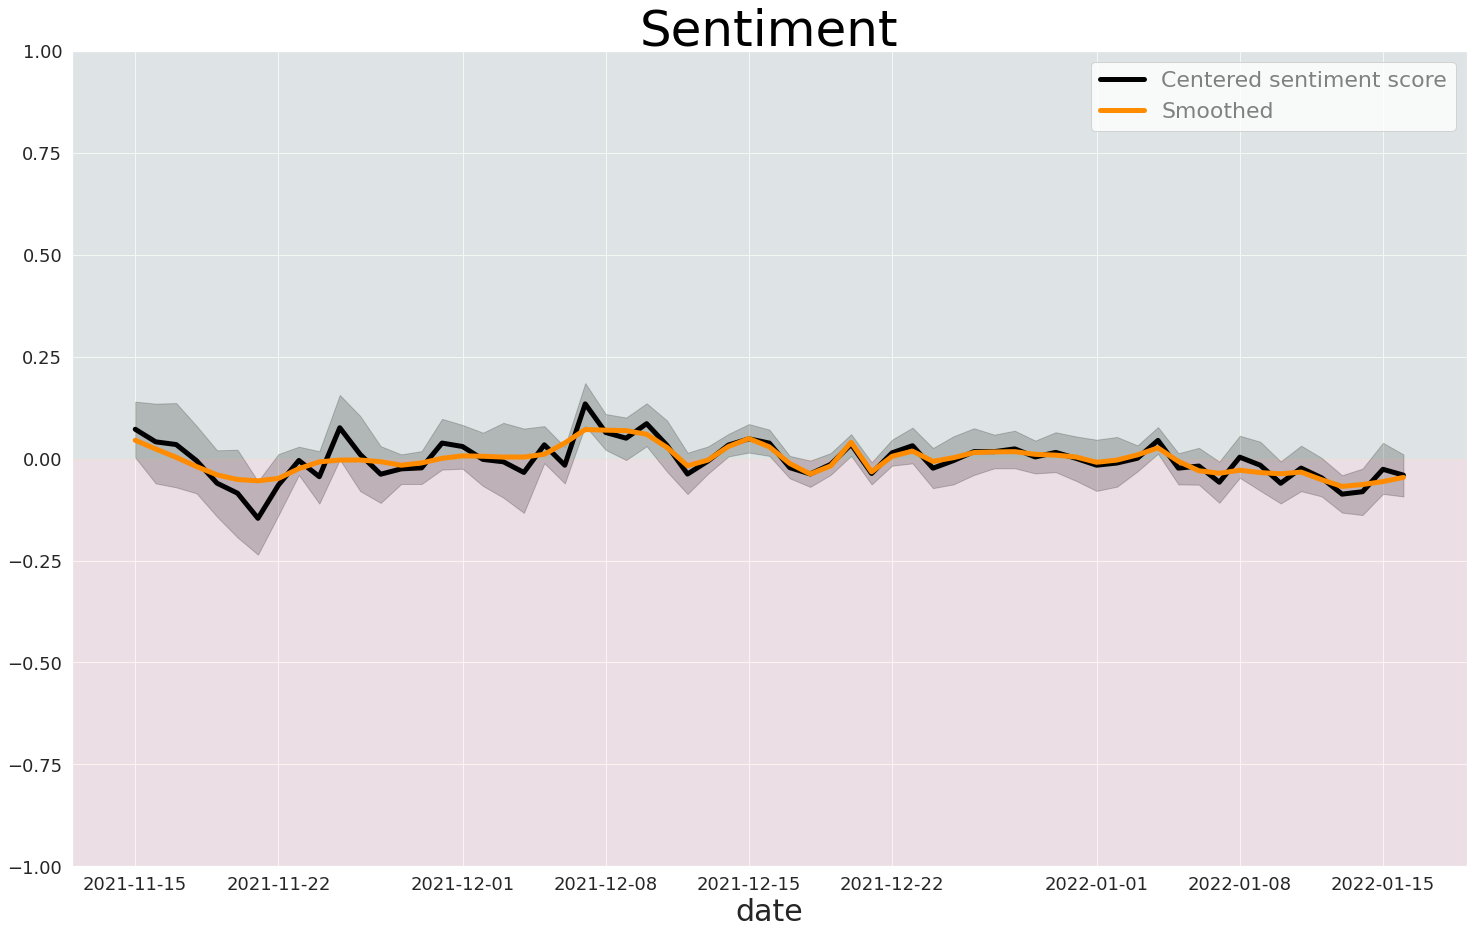

In [57]:
time_scale = "date" #use "Week" or "date"
smoothing_value = 500
polarity = False
save = True

fig, ax1 = plt.subplots(1,1, figsize = (25,15))
themes.theme_minimal(grid=True, ticks=True, fontsize=30)

if polarity: 
  ax1 = sns.lineplot(x=time_scale, y="polarity_score_z", 
                  color = "Black", 
                   #alpha = 0.30,
                     linewidth = 5, data = df)

  ax1 = sns.lineplot(x=time_scale, y=f"s{smoothing_value}_polarity_score_z", 
                  color = "darkorange", 
                      linewidth = 5, data = df)
  plot_name = f"../fig/{data_prefix}/{data_prefix}_sentiment_{time_scale}_polarity.png"
  plt.legend(labels=['z(Polarity score)', 'Smoothed'])

else:
  ax1 = sns.lineplot(x=time_scale, y="centered_compound", 
                    color = "Black", 
                    #alpha = 0.30,
                      linewidth = 5, data = df)

  ax1 = sns.lineplot(x=time_scale, y=f"s{smoothing_value}_compound", 
                  color = "darkorange", 
                      linewidth = 5, data = df)
  plot_name = f"../fig/{data_prefix}/{data_prefix}_sentiment_{time_scale}.png"
  plt.legend(labels=['Centered sentiment score', 'Smoothed'])

# For jul split
# ax1 = sns.lineplot(x=time_scale, y=f"split_smooth_compund_{smoothing_value}", 
#                  color = "darkorange", 
#                     linewidth = 5, data = df)

ax1.set_ylim(ymin = -1, ymax = 1)
ax1.set(xlabel=time_scale, ylabel = "")
ax1.xaxis.get_label().set_fontsize(30)
ax1.yaxis.get_label().set_fontsize(30)

plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)

plt.axhspan(0, 1, color = "green", facecolor='0.1', alpha=0.05)
plt.axhspan(0, -1, color = "red", facecolor='0.', alpha=0.05)

ax1.set_title("Sentiment", fontdict = {'fontsize':50}, color = "Black")

if save:
  fig.savefig(plot_name)

fig.show()

# Hashtags

In [58]:
import re

def extract_hashtags(row):
    unique_hashtag_list = list(re.findall(r'#\S*\w', row["text"]))
    return unique_hashtag_list

def hashtag_per_row(data):
    # Create hashtags column with the actual unique hashtags
    data["hashtags"] = data.apply(lambda row: extract_hashtags(row), axis = 1)

    # Let's take a subset of necessary columns, add id
    df = data[["date", "hashtags"]].reset_index().rename(columns={"index": "id"})

    # Select only the ones where we have more than 1 hashtag per tweet
    df = df[df["hashtags"].map(len) > 1].reset_index(drop=True)

    # Hashtag per row
    # convert list of pd.Series then stack it
    df = (df
     .set_index(['date','id'])['hashtags']
     .apply(pd.Series)
     .stack()
     .reset_index()
     .drop('level_2', axis=1)
     .rename(columns={0:'hashtag'}))
    #lowercase!
    df["hashtag"] = df["hashtag"].str.lower()
    df["hashtag"] = df["hashtag"].str.replace("'.", "")
    df["hashtag"] = df["hashtag"].str.replace("’.", "")

    return df

# Aggregate a frequency DF
def get_hashtag_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_hashtags' : df.groupby(['hashtag']).size()}).reset_index()
    return tweet_freq

In [59]:
hashtags = hashtag_per_row(df)
freq_hashtags = get_hashtag_frequencies(hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)
df0 = df1.nlargest(30, columns=['nr_of_hashtags'])

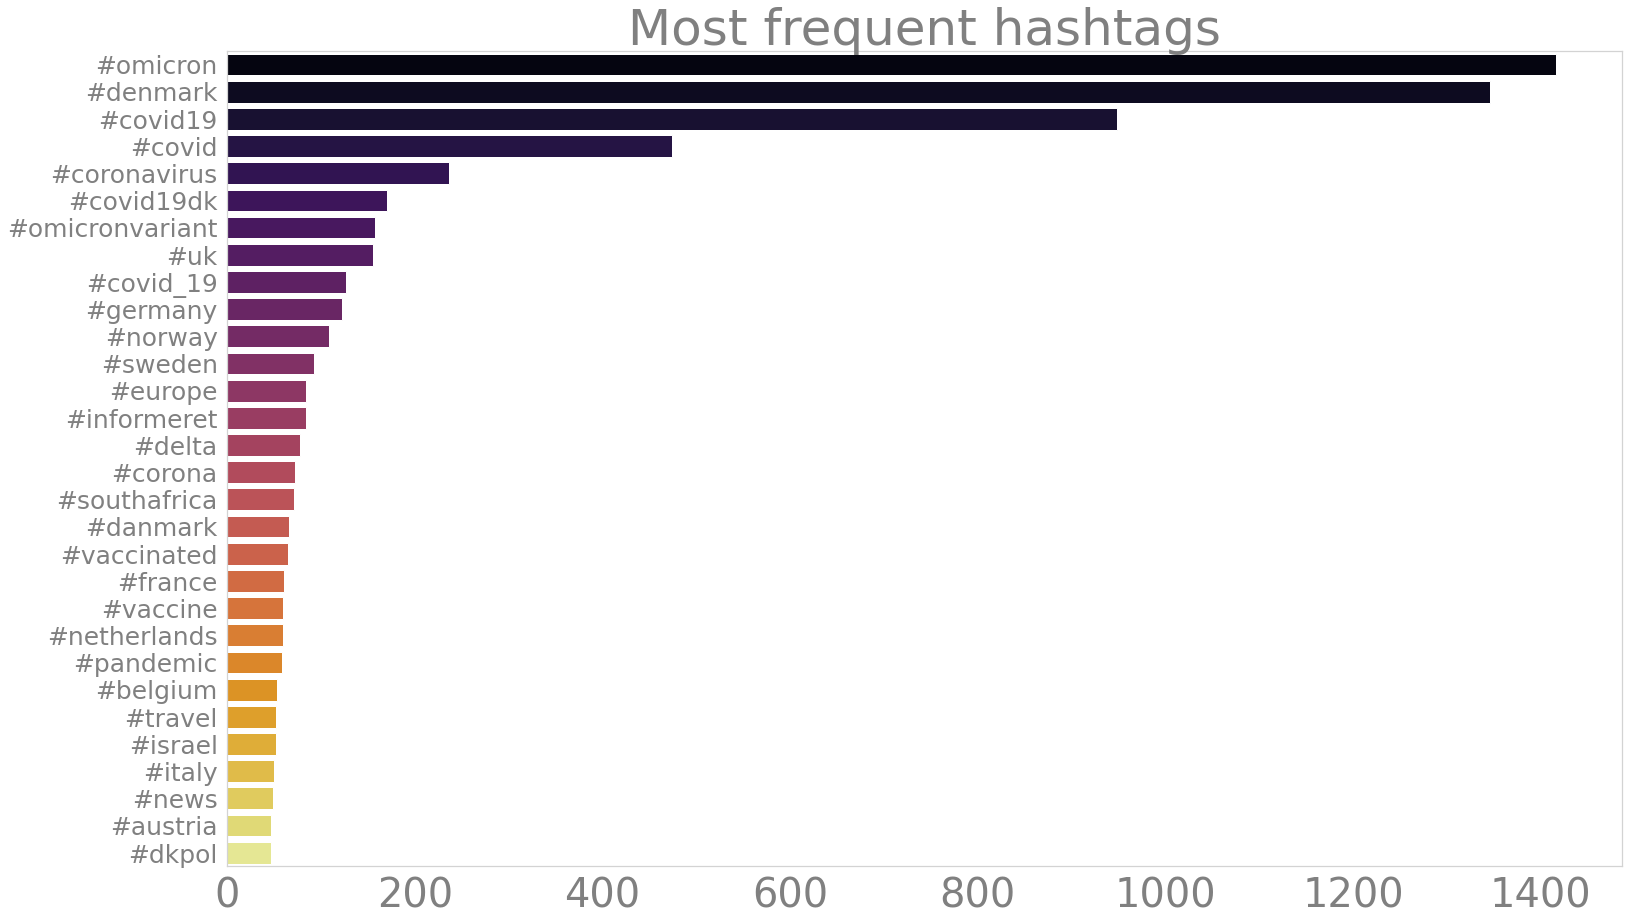

In [60]:
save = True

#Setup
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
themes.theme_minimal(grid=False, ticks=False, fontsize=40)
a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

nr_hash = len(df0["hashtag"].unique())
palette = sns.color_palette("inferno", nr_hash)

#Plot
ax = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = palette, data = df0)

#Axes
ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = f"../fig/{data_prefix}/{data_prefix}_frequent_hashtags.png"
if save:
    fig.savefig(plot_name)

# Most frequent words

In [61]:
import spacy
import string
from string import digits
import re

In [40]:
sp = spacy.load('da_core_news_lg')

file = open("../src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

/home/stine/.virtualenvs/hope/lib/python3.6/site-packages/spacy/util.py:1636: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [62]:
texts = df["tokens_string"]
word_freq = df.tokens_string.str.split(expand=True).stack().value_counts()
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})
df0 = word_freq.nlargest(30, columns=['Frequency'])

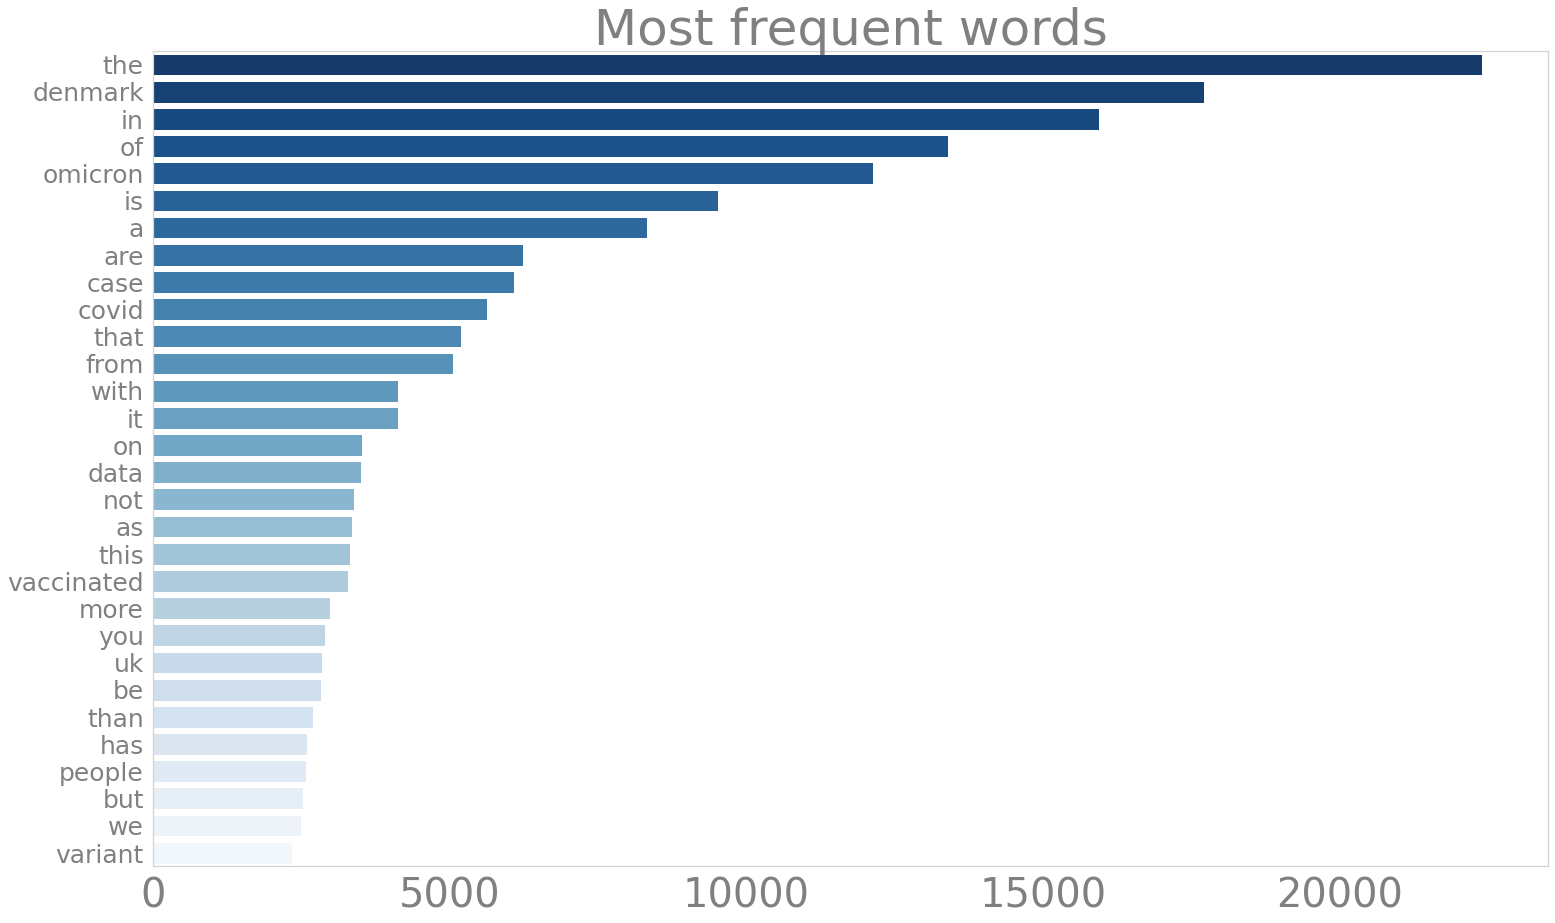

In [63]:
save = True
#Prepare plot
matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)
themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

n_words = len(df0["word"].unique())
palette = sns.color_palette("Blues_r", n_words)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = f"../fig/{data_prefix}/{data_prefix}_word_frequency.png"
if save:
    fig.savefig(plot_name)

# Bigrams

In [64]:
import ast
from nltk.util import bigrams
import itertools
import collections
import networkx as nx

In [65]:
terms_bigram = [list(bigrams(ast.literal_eval(tweet))) for tweet in df['tokens_list']]
# Flatten list of bigrams in clean tweets
bigrms = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrms)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

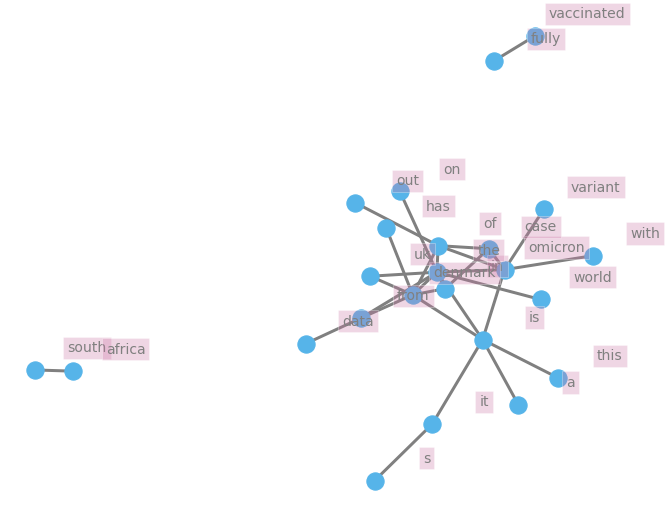

In [70]:
save = True
k = 5
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
scale_nodes = False

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for key, value in d[0].items():
    G.add_edge(key[0], key[1], weight=(value * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=k)

# Nodes
d = word_freq.to_dict(orient = 'split')['data']
d = [(int(word[1]))*2 for node in G.nodes() for word in d if word[0] == node]

if scale_nodes:
    # Plot networks
    nx.draw_networkx(G, pos,
                    font_size=10,
                    width=3,
                    edge_color= "grey",#palette[0], #'red',
                    node_color= palette[2], #'green',
                    node_size = d,
                    with_labels = False,
                    ax=ax)
else:
    nx.draw_networkx(G, pos,
                    font_size=10,
                    width=3,
                    edge_color= "grey",#palette[0], #'red',
                    node_color= palette[2], #'green',
                    with_labels = False,
                    ax=ax)
# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

if save and scale_nodes:
    plt.savefig(f"../fig/{data_prefix}/{data_prefix}_bigram_graph_scaled.png", dpi=150)
else:
    plt.savefig(f"../fig/{data_prefix}/{data_prefix}_bigram_graph.png", dpi=150)

plt.show()

# Wordcloud

In [14]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes
from wordcloud import WordCloud, STOPWORDS
import string
import spacy

In [9]:
# texts = ", ".join(texts)
# texts = texts.translate(str.maketrans('', '', string.punctuation))
# texts = texts.lower()
texts = df["tokens_string"]
texts = texts[texts.notnull()] #Sometimes necessary
texts = ", ".join(texts)

In [15]:
sp = spacy.load('da_core_news_lg')

file = open("../src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

In [10]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, save=False):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = f"../fig/{data_prefix}/{data_prefix}_word_cloud.png"
    if save:
        plt.savefig(plot_name)

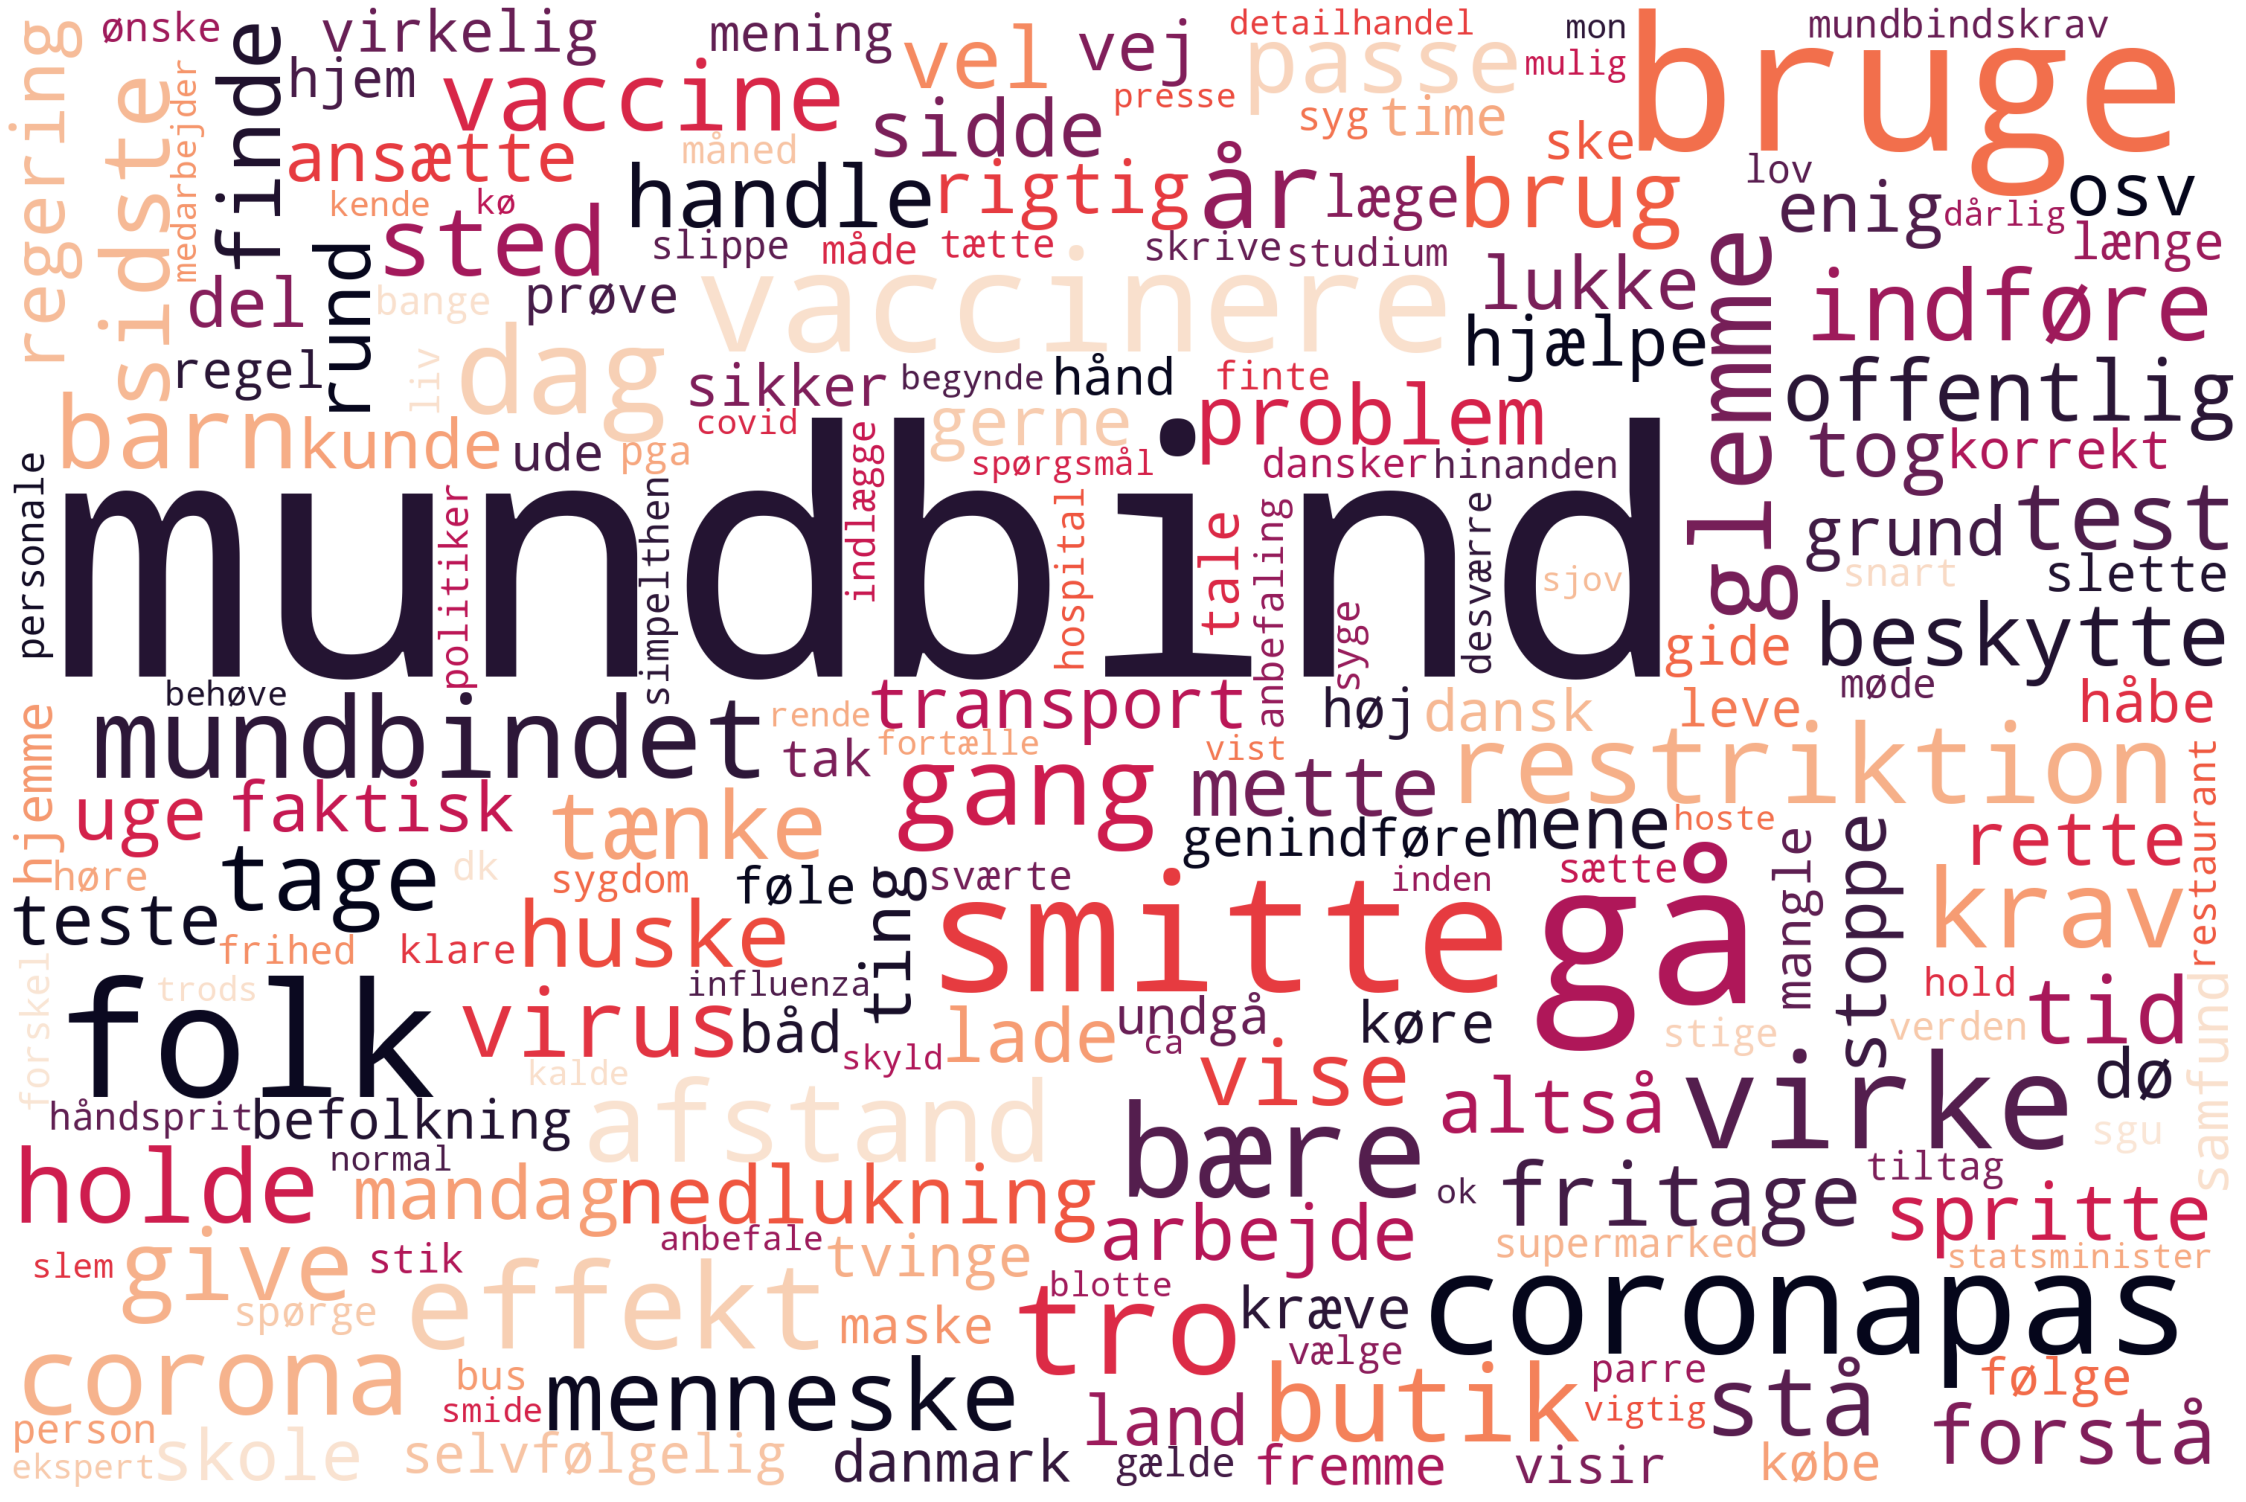

In [16]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = my_stop_words).generate(texts)
# Plot
plot_cloud(wordcloud, save=False)

In [20]:
type(texts)

str

In [21]:
my_stop_words

['ad',
 'af',
 'aldrig',
 'alene',
 'alle',
 'allerede',
 'alligevel',
 'alt',
 'altid',
 'and',
 'anden',
 'anden',
 'at',
 'bag',
 'bare',
 'begge',
 'bl.a.',
 'blandt',
 'blive',
 'blive',
 'blive',
 'burde',
 'bør',
 'ca.',
 'da',
 'de',
 'de',
 'den',
 'denne',
 'dens',
 'der',
 'derefter',
 'deres',
 'derfor',
 'derfra',
 'deri',
 'dermed',
 'derpå',
 'derved',
 'det',
 'denne',
 'du',
 'din',
 'din',
 'denne',
 'dit',
 'dog',
 'du',
 'efter',
 'eg',
 'ej',
 'eller',
 'ellers',
 'en',
 'ende',
 'endnu',
 'ene',
 'eneste',
 'enhver',
 'ens',
 'enten',
 'være',
 'en',
 'f.eks.',
 'far',
 'fem',
 'få',
 'fire',
 'flere',
 'flest',
 'fleste',
 'for',
 'foran',
 'fordi',
 'forrige',
 'fra',
 'fx',
 'få',
 'få',
 'føre',
 'først',
 'gennem',
 'gøre',
 'gøre',
 'god',
 'godte',
 'gø',
 'gøre',
 'gøre',
 'han',
 'han',
 'hans',
 'have',
 'have',
 'hav',
 'hej',
 'hele',
 'heller',
 'helt',
 'hen',
 'hun',
 'hendes',
 'henover',
 'her',
 'herefter',
 'heri',
 'hermed',
 'herpå',
 'hos',
 